<a href="https://colab.research.google.com/github/TAMIDSpiyalong/Decision-Science-for-Sustainable-Livestock-Systems/blob/main/computer_vision_for_feed_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem

This lecture explores the potential of computer vision in precision livestock farming, focusing on its applications in automated feeding grading tasks. The example image dataset is collected from a Calan Gate Feeding System on a research facility at Texas A&M University, Department of Animal Science, College Station, TX.

# Objectives

* Understanding the mathmatics behind the neural network
* Create a simple neural network to perform image classification
* Create a convolutional neural network (CNN) for the same problem
* Use transfer learning to build a ResNet for the same problem
* Understand the prediction and evaluate the computer vision performance

In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import seaborn as sn
import pandas as pd


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data

To monitor the feeding behavior of the beef cattles, we installed a high-definition video capture system, which consisted of three Reolink PoE cameras (Model D400) positioned above the feeding bunks to cover all bunks, with each camera capturing two bunks. The cameras were configured to record at a resolution of Full HD (1920x1080 pixels) with a frame rate of 30 frames per second (FPS).

Consecutive frames are extracted from livestock monitoring videos and cropped to focus only on feeding bunks. The pixel coordinates of the feed bunks in the cameras are hand-picked, which will vary from camera to camera but remain the same for fixed cameras. The time of each frame is derived using its FPS rate based on the beginning time of the videos.


In [ ]:
import gdown
import os

if "mixture.zip" not in os.listdir():

  gdown.download('https://drive.google.com/uc?export=download&id=1nhqowKssfpHaGFhK6ilIuC0zYEBoeZ_4')
  ! unzip -q "mixture.zip"



Based on the following literature, we define the six different bunk scores from S00 to S4: S00 (no feed), S05 (scattered feed), S10 (thin layer), S20 (25-50%), S30 (> 50%), and S40 (untouched) (Lundy et al., 2015). Open the images in the file explore you can see the examples.

Lundy, E., Loy, D., Dahlke, G., 2015. Iowa Beef Center Feed Bunk Management.  https://store.extension.iastate.edu/product/4593


## Load Images

torchvision.datasets.ImageFolder is a PyTorch class that simplifies loading image datasets by organizing them into a directory structure where each subdirectory represents a class or category of images. In practice, it is more complicated but doable with care.

In [ ]:
images = torchvision.datasets.ImageFolder('mixture/')

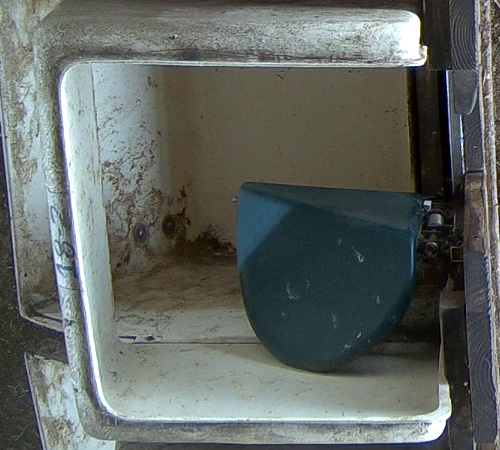

In [ ]:
images[4][0]

In [ ]:
print(np.array(images[4][0]).shape)

(450, 500, 3)


## Image Transformation

PyTorch transformations are crucial for preparing datasets before training machine learning models. They ensure standardization and normalization, which scale data points uniformly to prevent features with large ranges from dominating the training process. Transformations also enable data augmentation through techniques like rotation, flipping, and cropping, helping prevent overfitting and improve model generalization. Additionally, transformations ensure consistency by resizing images to uniform dimensions, which is necessary for batch processing in neural networks.

In [ ]:
import torchvision.transforms as transforms

# this is the mean and standard deviation for imagenet dataset
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
        # transforms.ColorJitter(brightness=(0.5, 1.5)),  # Adjust brightness
        transforms.Resize((64,64)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(mean, std),
        transforms.Grayscale()
    ])

In [ ]:
images = torchvision.datasets.ImageFolder('mixture/',transform)


['S00', 'S05', 'S10', 'S20', 'S30', 'S40']
183
2
torch.Size([1, 64, 64])
2
tensor([[[ 56.0114,  55.0115,  71.0099,  ...,  72.7630, 102.3749, 147.4350],
         [ 49.5991,  49.0121,  52.0118,  ...,  72.6490, 101.1470, 146.9081],
         [ 43.7137,  42.7138,  47.0123,  ...,  73.8769, 101.2071, 145.5662],
         ...,
         [ 25.0917,  33.2049,  45.9756,  ..., 116.5494, 126.2217,  64.2557],
         [ 23.4231,  17.2496,  23.6188,  ..., 118.1363, 119.2825,  65.1847],
         [ 13.3532,   9.5215,  11.4181,  ..., 109.3221, 108.9846,  78.5855]]]) 0


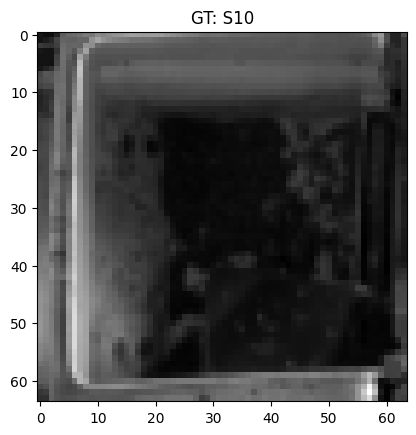

In [ ]:

class_names = images.classes
print(images.classes)
print(len(images))
print(len(images[99]))

image_tensor = images[100][0]

print(image_tensor.shape)

image_label = images[100][1]

print(image_label)

print(images[0][0]*255,images[0][1])

image_to_display = image_tensor.permute(1, 2, 0).cpu().numpy()

# Display the image
plt.title('GT: '+class_names[int(image_label)])
plt.imshow(image_to_display, cmap='gray')
plt.show()


In [ ]:
image_to_display.shape

(64, 64, 1)

## Data Split for Training, Validation, and Testing

In [ ]:
data_size = len(images.imgs)
train_size = int(data_size*0.7)
val_size = (data_size-train_size)//2
test_size = data_size-train_size-val_size
train_set, val_set, test_set = torch.utils.data.random_split(images, (train_size,val_size,test_size))
train_size,test_size,val_size

(128, 28, 27)

## Dataloader

PyTorch's DataLoader is crucial for efficiently handling large datasets and optimizing the data loading process in deep learning workflows. It allows you to split your dataset into batches, providing an iterable interface to access these batches sequentially, which is essential for training neural networks.

In [ ]:
from torch.utils.data import DataLoader

batch_size=32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)


### visualize the input examples

['S10', 'S20', 'S05', 'S05', 'S30', 'S40', 'S40', 'S10', 'S30', 'S30', 'S10', 'S05', 'S10', 'S05', 'S05', 'S10', 'S30', 'S30', 'S00', 'S30', 'S40', 'S10', 'S00', 'S05', 'S05', 'S30', 'S05', 'S30', 'S10', 'S05', 'S30', 'S20']


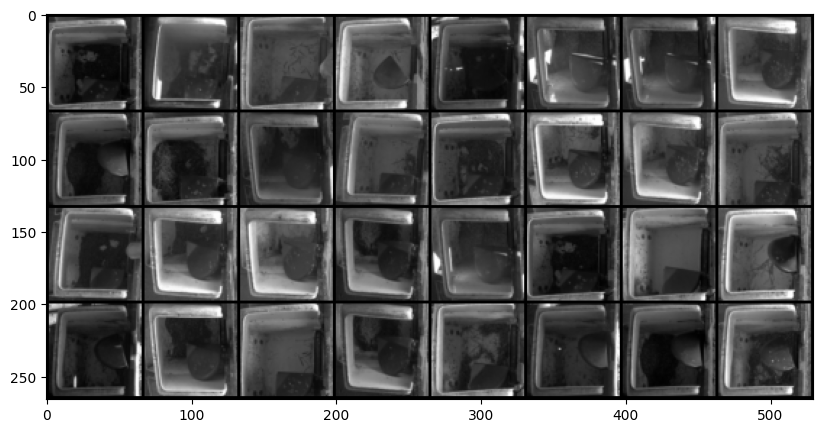

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # inp = std * inp + mean # correct the nornalization
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10,5))
imshow(out, title='Input Examples')
print([class_names[i] for i in classes])

In [ ]:
test_set[0][0].shape

torch.Size([1, 64, 64])

### Result Visualization

# Simple Neural Network

In [ ]:
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(4096, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 6)    # Output layer is the same dimension as the classes

    def forward(self, x):
        x = x.view(-1, 4096)  # Flatten the input
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)



In [ ]:
since = time.time()

best_acc = 0.0
num_epochs=20

for epoch in range(num_epochs):
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)

    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Each epoch has a validation phase

    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


----------
Epoch 1/20, Training Loss: 1.8139, Training Accuracy: 0.14%
Epoch 1/20, Validation Loss: 1.8067, validation Accuracy: 0.19%
----------
Epoch 2/20, Training Loss: 1.8127, Training Accuracy: 0.16%
Epoch 2/20, Validation Loss: 1.8050, validation Accuracy: 0.22%
----------
Epoch 3/20, Training Loss: 1.8103, Training Accuracy: 0.19%
Epoch 3/20, Validation Loss: 1.8028, validation Accuracy: 0.22%
----------
Epoch 4/20, Training Loss: 1.8076, Training Accuracy: 0.19%
Epoch 4/20, Validation Loss: 1.8003, validation Accuracy: 0.22%
----------
Epoch 5/20, Training Loss: 1.8044, Training Accuracy: 0.20%
Epoch 5/20, Validation Loss: 1.7977, validation Accuracy: 0.22%
----------
Epoch 6/20, Training Loss: 1.8014, Training Accuracy: 0.19%
Epoch 6/20, Validation Loss: 1.7949, validation Accuracy: 0.22%
----------
Epoch 7/20, Training Loss: 1.7981, Training Accuracy: 0.20%
Epoch 7/20, Validation Loss: 1.7922, validation Accuracy: 0.26%
----------
Epoch 8/20, Training Loss: 1.7949, Training 

## Train a Model with Pretrained Weights

In [ ]:

model = torchvision.models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)

model = model.to(device)


In [ ]:
since = time.time()

best_acc = 0.0
num_epochs=20

for epoch in range(num_epochs):
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)

    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Each epoch has a validation phase

    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


----------
Epoch 1/20, Training Loss: 1.8170, Training Accuracy: 0.31%
Epoch 1/20, Validation Loss: 1.7061, validation Accuracy: 0.26%
----------
Epoch 2/20, Training Loss: 0.7077, Training Accuracy: 0.79%
Epoch 2/20, Validation Loss: 1.7031, validation Accuracy: 0.26%
----------
Epoch 3/20, Training Loss: 0.3262, Training Accuracy: 0.97%
Epoch 3/20, Validation Loss: 1.7269, validation Accuracy: 0.26%
----------
Epoch 4/20, Training Loss: 0.1553, Training Accuracy: 1.00%
Epoch 4/20, Validation Loss: 1.7105, validation Accuracy: 0.30%
----------
Epoch 5/20, Training Loss: 0.0880, Training Accuracy: 1.00%
Epoch 5/20, Validation Loss: 1.6975, validation Accuracy: 0.26%
----------
Epoch 6/20, Training Loss: 0.0485, Training Accuracy: 1.00%
Epoch 6/20, Validation Loss: 1.7060, validation Accuracy: 0.26%
----------
Epoch 7/20, Training Loss: 0.0334, Training Accuracy: 1.00%
Epoch 7/20, Validation Loss: 1.7729, validation Accuracy: 0.30%
----------
Epoch 8/20, Training Loss: 0.0232, Training 

### Saving the Best Model and Load

In [ ]:
torch.save(best_model, 'best_model.pth')

This is testing on the testing portion, which is from the same mixture.

In [ ]:


model = torchvision.models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)

model.load_state_dict(torch.load('best_model.pth'))

model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


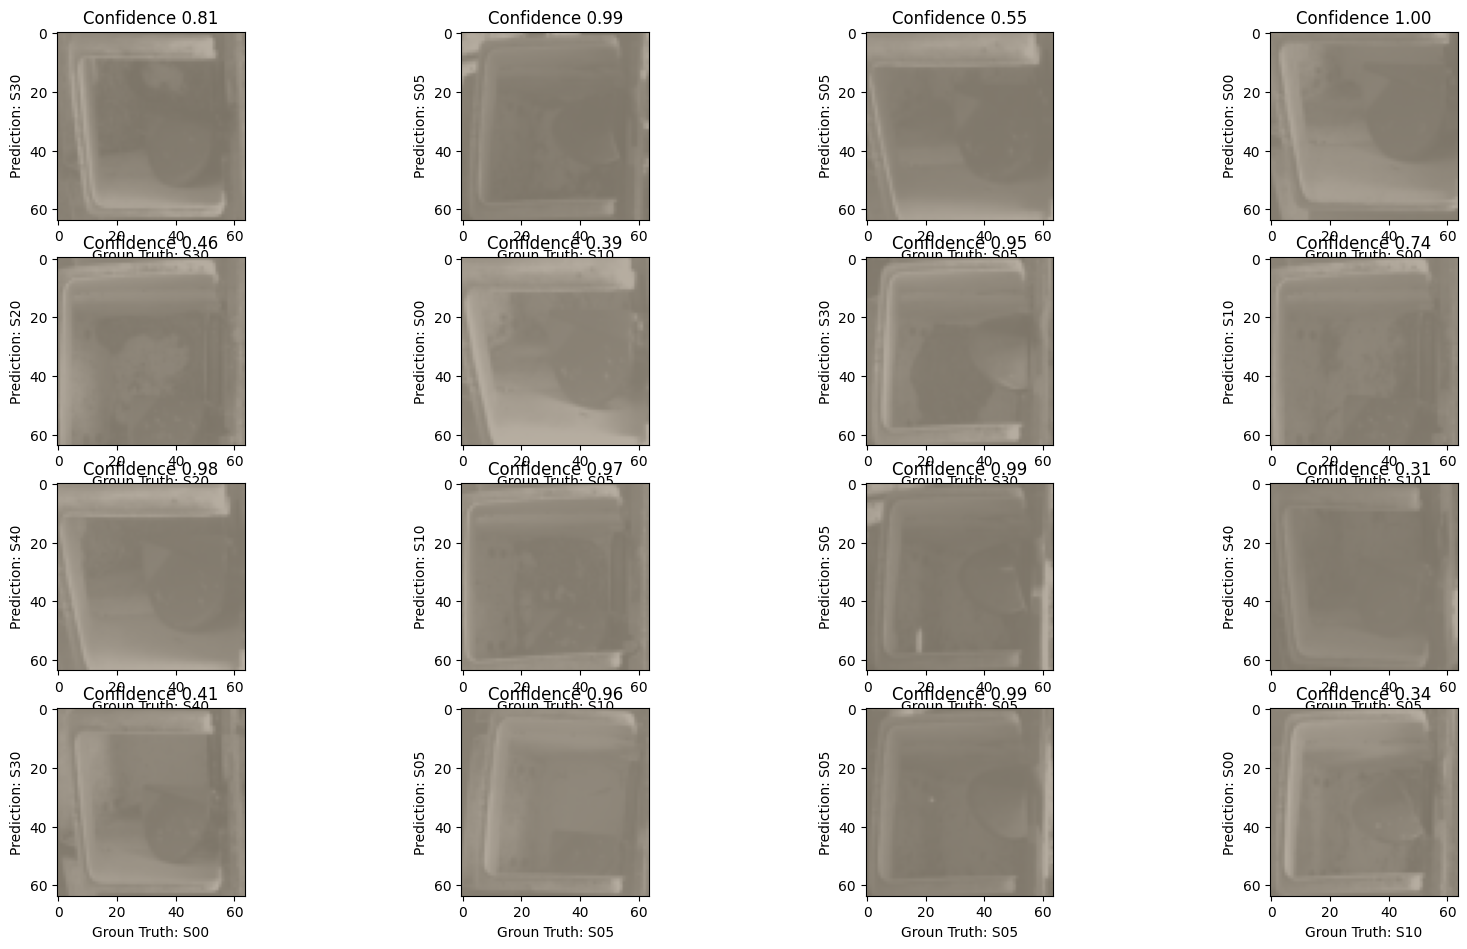

In [ ]:
model.eval()
images_so_far = 0
fig = plt.figure(figsize=(20,20))
sm = torch.nn.Softmax()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        l=labels
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        confidence = np.amax(np.array(sm(outputs.cpu())),1)
#             break
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(len(inputs)//4, 4, images_so_far)
            ax.set_xlabel('Groun Truth: {}'.format(class_names[l[j]]))
            ax.set_ylabel('Prediction: {}'.format(class_names[preds[j]]))
            ax.set_title('Confidence {:.2f}'.format(confidence[j]))

            inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            ax.imshow(inp)
            if images_so_far == 16:
                break

# Test on unseen data

Now we make the test dataloader to load the random selected pictures and get the confusion matrix. We can see the model works for the random selected pictures. The key for next steps is to get diverse training dataset to cover many different conditions. This also can be done by data augmentation.

"1zMIA-i0_M6mVPCnMshJQxgVXz8u_m40r"

In [ ]:
if "RANDOM_PICTURES_TO_VERIFY.zip" not in os.listdir():

    gdown.download('https://drive.google.com/uc?export=download&id=1zMIA-i0_M6mVPCnMshJQxgVXz8u_m40r')
    ! unzip -q 'RANDOM_PICTURES_TO_VERIFY.zip'

replace RANDOM_PICTURES_TO_VERIFY/S00/FB_01_2023-11-10_NVRCH02-095815-095830_S1.0_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
test_set = torchvision.datasets.ImageFolder('RANDOM_PICTURES_TO_VERIFY/',transform)


In [ ]:
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)


## Confusion Matrix Result Analysis

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
model.to(device)
with torch.no_grad():

    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 906.,    0.,    0.,    0.,    0.,    0.],
        [   0., 2926.,  246.,    0.,    5.,   12.],
        [   0.,  391.,  806.,  110.,   31.,    0.],
        [   0.,   15.,   15.,  602.,   50.,    0.],
        [  18.,    0.,    0.,  151., 1054.,   30.],
        [   0.,    6.,    0.,    0.,   76.,  455.]])


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


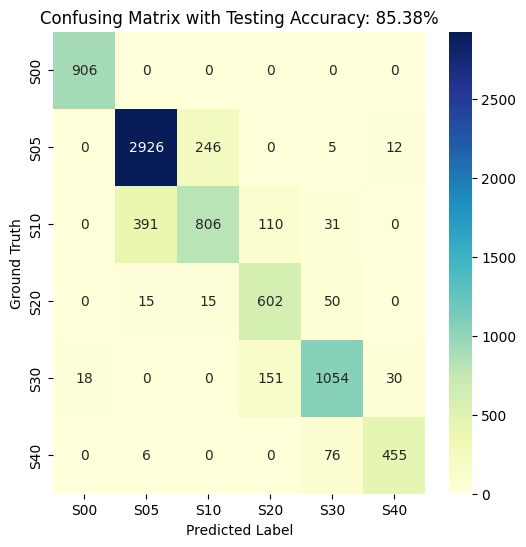

In [ ]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype('int'), index = [i for i in class_names],
                  columns = [i for i in class_names])

test_acc=np.trace(confusion_matrix.numpy().astype('int'))/np.sum(np.sum(df_cm))

plt.figure(figsize = (len(class_names),len(class_names)))
plt.title('Confusing Matrix with Testing Accuracy: {:0.2f}%'.format(test_acc*100))

sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')
plt.savefig('Confusing Matrix.pdf',dpi=300)

In [ ]:
cm=confusion_matrix.numpy().astype('int')
recall = np.diag(cm) /( np.sum(cm, axis = 1)+0.000000001)
precision = np.diag(cm) /( np.sum(cm, axis = 0)+0.000000001)
f1_per_class = 2 * (precision * recall) / (precision + recall)

data = {'Class': images.classes, 'Precision': precision, 'Recall': recall, 'F1': f1_per_class}
df = pd.DataFrame(data)

styled_df = df.style.format({'Precision': '{:.2%}', 'Recall': '{:.2%}','F1': '{:.2%}'})

print(styled_df)

# Save the DataFrame to a CSV file
df.to_csv('precision_recall_table.csv', index=False)

In [ ]:
len(test_set)

7905

In [ ]:

f1_per_class

array([0.99016393, 0.89658342, 0.67027027, 0.77928803, 0.85378696,
       0.88007737])

In [ ]:
df

,Class,Precision,Recall,F1
0,S00,0.980519,1.000000,0.990164
1,S05,0.876573,0.917529,0.896583
2,S10,0.755389,0.602392,0.670270
3,S20,0.697567,0.882698,0.779288
4,S30,0.866776,0.841181,0.853787
5,S40,0.915493,0.847300,0.880077


In [ ]:
styled_df = df.style.format({'Precision': '{:.2%}', 'Recall': '{:.2%}','F1': '{:.2%}'})
styled_df

,Class,Precision,Recall,F1
0,S00,98.05%,100.00%,99.02%
1,S05,87.66%,91.75%,89.66%
2,S10,75.54%,60.24%,67.03%
3,S20,69.76%,88.27%,77.93%
4,S30,86.68%,84.12%,85.38%
5,S40,91.55%,84.73%,88.01%


In [ ]:
classes

tensor([5], device='cuda:0')

Ground truth label is a S00
tensor([[ 9.9134, -1.1909, -1.8213, -3.4545, -2.4247, -0.7827]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Prediction is a S00
[[9.9994838e-01 1.5045978e-05 8.0102236e-06 1.5643858e-06 4.3811565e-06
  2.2632466e-05]]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Text(0.5, 1.0, 'Confidence for each class')

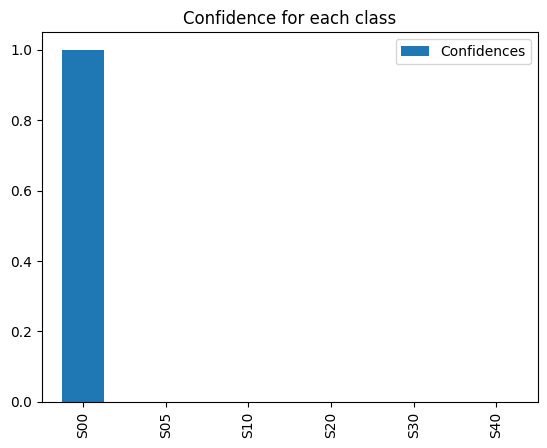

In [ ]:
inputs, classes = next(iter(test_dataloader))

image = inputs[0].to(device).unsqueeze(0)

outputs = model(image)

print('Ground truth label is a {}'.format(class_names[classes[0]]))

print(outputs)

_, preds = torch.max(outputs, 1)
print('Prediction is a {}'.format(class_names[preds]))

sm = torch.nn.Softmax()
confidences = np.array(sm(outputs.cpu().detach()))
print(confidences)

df = pd.DataFrame({'Confidences':confidences[0]},index=class_names)
df.plot.bar()
plt.title('Confidence for each class')